# Setup

In [34]:
import os
from pathlib import Path
from typing import Iterable, List, Tuple
from statistics import mean

from PIL import Image
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn
import torchvision
import torch.nn.functional as F


In [2]:
INPUT_DIR = Path(os.environ["INPUT_DIR"])
assert INPUT_DIR.exists()
assert INPUT_DIR.is_dir()


In [3]:
list(INPUT_DIR.glob("**/*"))


[PosixPath('/inputs/.gitkeep'),
 PosixPath('/inputs/MNIST'),
 PosixPath('/inputs/MNIST/raw'),
 PosixPath('/inputs/MNIST/raw/train-images-idx3-ubyte'),
 PosixPath('/inputs/MNIST/raw/t10k-images-idx3-ubyte'),
 PosixPath('/inputs/MNIST/raw/train-labels-idx1-ubyte'),
 PosixPath('/inputs/MNIST/raw/t10k-labels-idx1-ubyte')]

In [4]:
OUTPUT_DIR = Path(os.environ["OUTPUT_DIR"])
assert OUTPUT_DIR.exists()
assert OUTPUT_DIR.is_dir()


# Load data

In [5]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)


In [6]:
train_ds = torchvision.datasets.MNIST(
    INPUT_DIR, train=True, download=False, transform=transform
)
eval_ds = torchvision.datasets.MNIST(
    INPUT_DIR, train=False, download=False, transform=transform
)


torch.Size([1, 28, 28])

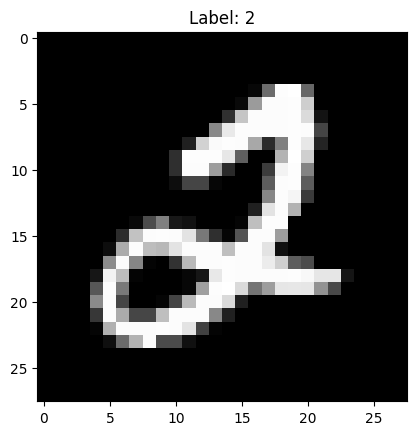

In [39]:
img, label = train_ds[np.random.randint(0, len(train_ds))]
plt.imshow(img[0], cmap="gray")
plt.title(f"Label: {label}")
img.shape


In [7]:
# split train ds into train and validation
generator = torch.Generator().manual_seed(42)
train_ds, val_ds = torch.utils.data.random_split(
    train_ds, [0.8, 0.2], generator=generator
)


In [8]:
batch_size = 32


In [9]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, num_workers=1, pin_memory=True, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, num_workers=1, pin_memory=True, shuffle=False
)
eval_loader = torch.utils.data.DataLoader(
    eval_ds, batch_size=batch_size, num_workers=1, pin_memory=True, shuffle=False
)


# Model architecture

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


# Training

In [11]:
device = torch.device("cuda")


In [12]:
model = Model().to(device)


In [13]:
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)


In [14]:
epochs = 20


In [15]:
def train(
    model: Model,
    device: torch.device,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
) -> Iterable[float]:
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss_value = loss.item()
        yield loss_value


In [16]:
def test(
    model: Model, device: torch.device, test_loader: torch.utils.data.DataLoader
) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return test_loss, correct / len(test_loader.dataset)


In [17]:
train_losses: List[float] = []
valid_losses: List[float] = []
valid_accuracies: List[float] = []
for epoch in trange(1, epochs + 1, desc="Epochs"):
    train_loss = mean(train(model, device, train_loader, optimizer))
    val_loss, val_accuracy = test(model, device, val_loader)
    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    valid_accuracies.append(val_accuracy)
    torch.save(
        {"model_state_dict": model.state_dict(), "epoch": epoch},
        OUTPUT_DIR / f"checkpoint_{epoch:02}.pth",
    )


Epochs: 100%|██████████| 20/20 [10:55<00:00, 32.76s/it]


In [18]:
best_epoch = np.argmin(valid_losses) + 1
print(
    f"Best epoch: {best_epoch} with loss: {valid_losses[best_epoch - 1]}, accuracy: {valid_accuracies[best_epoch - 1]}"
)


Best epoch: 9 with loss: 0.0482392591139178, accuracy: 0.9880833333333333


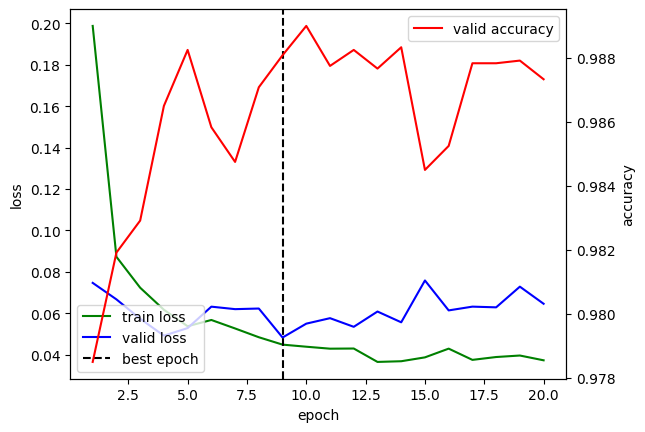

In [23]:
# draw loss and accuracy during training. accuracy should be printed on twin axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), train_losses, label="train loss", color="green")
ax1.plot(range(1, epochs + 1), valid_losses, label="valid loss", color="blue")
ax2.plot(range(1, epochs + 1), valid_accuracies, label="valid accuracy", color="red")
ax1.axvline(best_epoch, color="black", linestyle="--", label="best epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
ax1.legend(loc="lower left")
ax2.legend(loc="upper right")
None


In [20]:
best_checkpoint_path = OUTPUT_DIR / f"checkpoint_{best_epoch:02}.pth"
best_checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(best_checkpoint["model_state_dict"])


<All keys matched successfully>

# Evaluation

In [21]:
eval_loss, eval_accuracy = test(model, device, eval_loader)
print(f"Eval loss: {eval_loss:.4f}, Eval accuracy: {eval_accuracy:.4f}")


Eval loss: 0.0345, Eval accuracy: 0.9896


# Check on custom image

In [60]:
img = Image.open(Path.cwd() / "6.png")


In [61]:
normalized = transform(img)


In [62]:
with torch.no_grad():
    output = model(normalized[None, ...].to(device))
    print("output", output)
    pred = output.argmax(dim=1, keepdim=True)
    print(f"Prediction: {pred.item()}")


output tensor([[-2.4395, -1.9117, -4.7813, -5.1761, -5.4450, -0.8115, -1.4025, -3.7197,
         -3.6011, -5.3165]], device='cuda:0')
Prediction: 5
